In [85]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix

In [86]:
#Caricamento dataset
train_path = './train.csv'
test_path = './test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

## Preprocessing

In [87]:
#Assign int values for y column
train['No-show'] = train['No-show'].map({'Yes':1, 'No':0})
test['No-show'] = test['No-show'].map({'Yes':1, 'No':0})

In [88]:
# Column data replace/Removing null values/ missing data -> NON TROVATI
#for i in ['listOfStuff']: 
#    train[i]  = train[i].replace({'' : '' or np.NaN})
#    test[i] = test[i].replace({'':'' or np.NaN})

In [89]:
#Drop nulli -> NON TROVATI
#train = train.dropna(axis=0)
#test = test.dropna(axis=0)

In [90]:
#Remove unusual data
train['Age'] = train['Age'].mask(train['Age']<0, np.NaN)
test['Age'] = test['Age'].mask(train['Age']<0, np.NaN)
train['Age'] = train['Age'].mask(train['Age']>100, np.NaN)
test['Age'] = test['Age'].mask(train['Age']>100, np.NaN)

train['Handcap'] = train['Handcap'].mask(train['Handcap']>0,1)
test['Handcap'] = test['Handcap'].mask(test['Handcap']>0,1)

train = train.dropna(axis=0)
test = test.dropna(axis=0)

In [91]:
#Add a column difference of days between scheduled and appointment
train['ScheduledDay'] = pd.to_datetime(train['ScheduledDay'])
train['Scheduled_Day'] = train['ScheduledDay'].dt.day
train['Scheduled_Month'] = train['ScheduledDay'].dt.month
train['Scheduled_Year'] = train['ScheduledDay'].dt.year
train['Scheduled_Hour'] = train['ScheduledDay'].dt.hour
train['Scheduled_Day_Of_Week'] = train['ScheduledDay'].dt.dayofweek
train['ScheduledDay'] = train['ScheduledDay'].dt.date
train['AppointmentDay'] = pd.to_datetime(train['AppointmentDay'])
train['Appointment_Day'] = train['AppointmentDay'].dt.day
train['Appointment_Month'] = train['AppointmentDay'].dt.month
train['Appointment_Year'] = train['AppointmentDay'].dt.year
train['Appointment_Day_Of_Week'] = train['AppointmentDay'].dt.dayofweek
train['AppointmentDay'] = train['AppointmentDay'].dt.date
train['Diff_Days_bw_Sch_App'] = ((train['AppointmentDay']-train['ScheduledDay']).dt.days)


test['ScheduledDay'] = pd.to_datetime(test['ScheduledDay'])
test['Scheduled_Day'] = test['ScheduledDay'].dt.day
test['Scheduled_Month'] = test['ScheduledDay'].dt.month
test['Scheduled_Year'] = test['ScheduledDay'].dt.year
test['Scheduled_Hour'] = test['ScheduledDay'].dt.hour
test['Scheduled_Day_Of_Week'] = test['ScheduledDay'].dt.dayofweek
test['ScheduledDay'] =test['ScheduledDay'].dt.date
test['AppointmentDay'] = pd.to_datetime(test['AppointmentDay'])
test['Appointment_Day'] = test['AppointmentDay'].dt.day
test['Appointment_Month'] = test['AppointmentDay'].dt.month
test['Appointment_Year'] = test['AppointmentDay'].dt.year
test['Appointment_Day_Of_Week'] = test['AppointmentDay'].dt.dayofweek
test['AppointmentDay'] =test['AppointmentDay'].dt.date

test['Diff_Days_bw_Sch_App'] = ((test['AppointmentDay']-test['ScheduledDay']).dt.days)


train=train[train['Diff_Days_bw_Sch_App']>=0]
test=test[test['Diff_Days_bw_Sch_App']>=0]

train = train.drop(columns='ScheduledDay')
test = test.drop(columns='ScheduledDay')
train = train.drop(columns='AppointmentDay')
test = test.drop(columns='AppointmentDay')

train['Scheduled_Day_Of_Week']

0        2
1        0
2        0
3        4
4        3
        ..
70731    0
70732    0
70733    2
70734    3
70735    0
Name: Scheduled_Day_Of_Week, Length: 70730, dtype: int64

In [92]:
#Gender and Alcoholism are nearly equal in relation to No-Show
checklist = ['Gender', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received']
for i in checklist:
    print(train.groupby(i)['No-show'].mean())

Gender
F    0.203119
M    0.200549
Name: No-show, dtype: float64
Scholarship
0    0.198210
1    0.238385
Name: No-show, dtype: float64
Hipertension
0    0.208809
1    0.175391
Name: No-show, dtype: float64
Diabetes
0    0.204202
1    0.176962
Name: No-show, dtype: float64
Alcoholism
0    0.202369
1    0.197536
Name: No-show, dtype: float64
SMS_received
0    0.167115
1    0.276194
Name: No-show, dtype: float64


In [93]:
test['Appointment_Year'].nunique()

1

In [94]:
test['Appointment_Year'].nunique()

1

In [95]:
#Identifying features
features = [ 'Diff_Days_bw_Sch_App', 'Scheduled_Day', 'Scheduled_Month', 
            'Scheduled_Year','Scheduled_Hour','Scheduled_Day_Of_Week', 'Appointment_Day', 'Appointment_Month',
            'Appointment_Day_Of_Week', 'Age','Neighbourhood', 'Scholarship', 'Hipertension',
            'Diabetes', 'Handcap', 'SMS_received']
non_numerical_features = ['Neighbourhood']

In [96]:
#Drop useless columns/ unique or with no correlation
train.index = train['AppointmentID']
test.index = test['AppointmentID']
train = train.drop(columns='AppointmentID')
test = test.drop(columns='AppointmentID')

In [97]:
#train['ScheduledDay'] = train['ScheduledDay'].astype(str)
#test['ScheduledDay'] = test['ScheduledDay'].astype(str)

#train['AppointmentDay'] = train['AppointmentDay'].astype(str)
#test['AppointmentDay'] = test['AppointmentDay'].astype(str)

In [98]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70730 entries, 5684848 to 5698984
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   No-show                  70730 non-null  int64  
 1   PatientId                70730 non-null  float64
 2   Gender                   70730 non-null  object 
 3   Age                      70730 non-null  float64
 4   Neighbourhood            70730 non-null  object 
 5   Scholarship              70730 non-null  int64  
 6   Hipertension             70730 non-null  int64  
 7   Diabetes                 70730 non-null  int64  
 8   Alcoholism               70730 non-null  int64  
 9   Handcap                  70730 non-null  int64  
 10  SMS_received             70730 non-null  int64  
 11  Scheduled_Day            70730 non-null  int64  
 12  Scheduled_Month          70730 non-null  int64  
 13  Scheduled_Year           70730 non-null  int64  
 14  Scheduled_Hour

In [99]:
#y contains previously unseen labels

# Encoding strings of the data set into labels
#le = preprocessing.LabelEncoder()
#for column in non_numerical_features:
#    print(column)
#    #le.fit(pd.concat([train[column],test[column]], axis=0, ignore_index=True))
#    le.fit(train[column])
#    test[column] = test[column].map(lambda s: '<unknown>' if s not in le.classes_ else s)
#    train[column] = le.fit_transform(train[column])
#    test[column] = le.transform(test[column])

label_train = train.copy()
label_test = test.copy()
le = preprocessing.LabelEncoder()
for column in non_numerical_features:
    label_train[column] = le.fit(train[column])
    label_test[column] = label_test[column].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '<unknown>')
    label_train[column] = le.transform(train[column])
    label_test[column] = le.transform(label_test[column])
    
train = label_train
test = label_test

In [100]:
train

,No-show,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,...,Scheduled_Day,Scheduled_Month,Scheduled_Year,Scheduled_Hour,Scheduled_Day_Of_Week,Appointment_Day,Appointment_Month,Appointment_Year,Appointment_Day_Of_Week,Diff_Days_bw_Sch_App
AppointmentID,,,,,,,,,,,,,,,,,,,,,
5684848,0,5.638379e+13,F,64.0,43,0,0,0,0,0,...,11,5,2016,9,2,13,5,2016,4,2
5742771,0,6.135766e+12,F,27.0,12,0,0,0,0,0,...,30,5,2016,8,0,30,5,2016,0,0
5643439,1,1.561163e+12,M,1.0,74,0,0,0,0,0,...,2,5,2016,7,0,17,5,2016,1,15
5767869,0,9.141757e+14,F,42.0,78,0,0,0,0,0,...,3,6,2016,7,4,3,6,2016,4,0
5766014,1,2.989500e+11,F,34.0,45,0,0,0,0,0,...,2,6,2016,14,3,3,6,2016,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5646982,1,4.117440e+12,F,79.0,29,0,1,0,0,0,...,2,5,2016,12,0,2,5,2016,0,0
5701381,1,7.476573e+12,M,44.0,40,0,1,0,0,0,...,16,5,2016,10,0,30,5,2016,0,14
5756917,0,9.484594e+14,F,45.0,36,0,0,0,0,0,...,1,6,2016,8,2,1,6,2016,2,0


In [101]:
for i in features:
    print(train.groupby(i)['No-show'].mean())

Diff_Days_bw_Sch_App
0      0.045810
1      0.214030
2      0.235049
3      0.231638
4      0.229001
         ...   
155    0.750000
162    0.250000
169    0.250000
176    0.333333
179    0.125000
Name: No-show, Length: 125, dtype: float64
Scheduled_Day
1     0.173482
2     0.160139
3     0.185940
4     0.204778
5     0.194650
6     0.172040
7     0.156211
8     0.132018
9     0.176540
10    0.166790
11    0.214490
12    0.200077
13    0.215180
14    0.382246
15    0.373041
16    0.178416
17    0.174394
18    0.228339
19    0.214437
20    0.213494
21    0.259259
22    0.319149
23    0.391304
24    0.151665
25    0.229154
26    0.326814
27    0.318890
28    0.296784
29    0.227685
30    0.151349
31    0.169246
Name: No-show, dtype: float64
Scheduled_Month
1     0.368421
2     0.289617
3     0.336481
4     0.313836
5     0.173865
6     0.097069
11    0.000000
12    0.315789
Name: No-show, dtype: float64
Scheduled_Year
2015    0.307692
2016    0.202162
Name: No-show, dtype: float64
Schedu

In [102]:
#Separate features from y
train_X = train[features]
train_y = train['No-show']
val_X = test[features]
val_y = test['No-show']

In [103]:
# More processing
sc = StandardScaler()
train_X = pd.DataFrame(sc.fit_transform(train_X))
val_X = pd.DataFrame(sc.transform(val_X))

## Addestramento

In [106]:
#RESULT: 79-79, best (slightly)
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0, max_depth=3, max_leaf_nodes=5)
model.fit(train_X,train_y)

predicted = model.predict(val_X)
mae = mean_absolute_error(val_y,predicted)
train_accuracy = model.score(train_X,train_y)*100
test_accuracy = model.score(val_X,val_y)*100

print(predicted)
print(mae)
print(train_accuracy)
print(test_accuracy)

[0 0 0 ... 0 0 0]
0.20214871359909528
79.77802912484094
79.78512864009048


In [105]:
#RESULT: 79-79
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs=-1)
model.fit(train_X, train_y)

predicted = model.predict(val_X)
mae = mean_absolute_error(val_y,predicted)
train_accuracy = model.score(train_X,train_y)*100
test_accuracy = model.score(val_X,val_y)*100

print('Mean absolute error: ')
print(mae)
print('Training set accuracy: ')
print(train_accuracy)
print('Test set accuracy: ')
print(test_accuracy)

Mean absolute error: 
0.20627650551314675
Training set accuracy: 
79.37226070974127
Test set accuracy: 
79.37234944868533


In [71]:
#RESULT
## TO CHECK WITH OTHER VARIABLES, LIKE NUMBER OF LEAVES
#from sklearn.tree import DecisionTreeClassifier
#best=[0,0,0,0,0]
#for j in range(2,50):
#    for i in range(1,10):
#        model = DecisionTreeClassifier(random_state=0, max_leaf_nodes = j, max_depth=i)
#        model.fit(train_X,train_y)
#        predicted = model.predict(val_X)
#        print(i)
#        mae = mean_absolute_error(val_y,predicted)
#        print(predicted)
#        train_accuracy = model.score(train_X,train_y)*100
#        test_accuracy = model.score(val_X,val_y)*100
#        print(mae)
#        print(train_accuracy)
#        print(test_accuracy)
#        if test_accuracy > best[2]:
#            best[0] = i
#            best[1] = train_accuracy
#            best[2] = test_accuracy
#            best[3] = mae
#            best[4] = j
#print(best)

In [72]:
#RESULT = overfit
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
model.fit(train_X, train_y)

predicted = model.predict(val_X)
mae = mean_absolute_error(val_y,predicted)

train_accuracy = model.score(train_X,train_y)*100
test_accuracy = model.score(val_X,val_y)*100

print(predicted)
print(mae)
print(train_accuracy)
print(test_accuracy)

[0 0 0 ... 0 0 0]
0.23138252756573366
83.50063622225365
76.86174724342663


In [73]:
#RESULT
#from sklearn.neighbors import KNeighborsClassifier
#results=[]
#best=[0,0,0,0]
#for i in range(1,30):
#    model = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
#    model.fit(train_X, train_y)
#    predicted = model.predict(val_X)
#    print(i)
#    mae = mean_absolute_error(val_y,predicted)
#    print(predicted)
#    train_accuracy = model.score(train_X,train_y)*100
#    test_accuracy = model.score(val_X,val_y)*100
#    print(mae)
#    print(train_accuracy)
#    print(test_accuracy)
#    results.append(mae) 
#    if test_accuracy > best[2]:
#        best[0] = i
#        best[1] = train_accuracy
#        best[2] = test_accuracy
#        best[3] = mae
#from statistics import mean
#mean(results)
#print(best) 

## Conclusione

In [74]:
#Classifier scelto: DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0, max_depth=3, max_leaf_nodes=5)
model.fit(train_X,train_y)

predicted = model.predict(val_X)
mae = mean_absolute_error(val_y,predicted)
train_accuracy = model.score(train_X,train_y)*100
test_accuracy = model.score(val_X,val_y)*100

print(predicted)
print(mae)
print(train_accuracy)
print(test_accuracy)

[0 0 0 ... 0 0 0]
0.20214871359909528
79.77802912484094
79.78512864009048


In [75]:
predicted = model.predict(val_X)
mae = mean_absolute_error(val_y,predicted)
train_accuracy = model.score(train_X,train_y)*100
test_accuracy = model.score(val_X,val_y)*100

print(predicted)
print(mae)
print(train_accuracy)
print(test_accuracy)

[0 0 0 ... 0 0 0]
0.20214871359909528
79.77802912484094
79.78512864009048


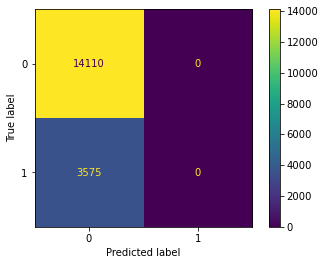

In [76]:
plot_confusion_matrix(model,val_X,val_y)